In [35]:
%run init_model.py 'algo_ml_long_short_predict'

algo_ml_long_short_predict


# Step 1) Data Preparation

In [36]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-demo-ver1'

In [37]:
import sys
!{sys.executable} -m pip install PyAthena
!{sys.executable} -m pip install --upgrade numexpr

In [38]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

In [39]:
import pandas as pd
from sqlalchemy import create_engine
from pyathena import connect
connection_string = 'awsathena+rest://@'+region+'?s3_staging_dir=s3://'+s3bucket+'/results/'
engine = create_engine(connection_string)
df = pd.read_sql("SELECT dt,open,high,low,close,vol FROM algo_data.hist_data_daily;", engine)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,open,high,low,close,vol
dt,,,,,
2012-08-13,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,26.57,26.63,26.21,26.33,30379903.0


In [40]:
trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local/'+algo_name+'/input/data/training/data_train.csv')
dfTest.head()

,open,high,low,close,vol
dt,,,,,
2014-08-13,33.24,34.15,33.23,34.10,36291008.0
2014-08-14,34.05,34.23,33.74,33.94,25457954.0
2014-08-15,34.10,34.21,33.71,34.17,28582224.0
2014-08-16,34.10,34.21,33.71,34.17,28582224.0
2014-08-17,34.10,34.21,33.71,34.17,28582224.0


<Axes: xlabel='dt'>

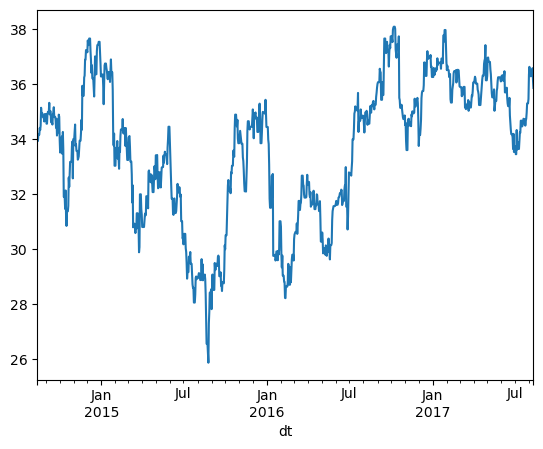

In [41]:
%matplotlib inline
dfTest["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, you can adjust the parameters for the strategy.

* `user` = Name for Leaderboard (optional)
* `long_threshold` = Threshold for Long Trade (0 to 1)
* `short_threshold` = Threshold for Short Trade (0 to 1)
* `profit_target_pct` = Profit Target Percentage 
* `stop_target_pct` = Stop Target Percentage
* `size` = The number of shares for a transaction

`Tip`: A good starting point for improving the strategy is modify the profit / stop target and the risk/reward ratio. Another option is to reduce the number of signals by increasing the threshold.

In [42]:
%%writefile local/{algo_name}/input/config/hyperparameters.json
{ "user" : "user",
  "long_threshold" : "0.5",
  "short_threshold" : "0.5",
  "profit_target_pct" : "2.00",
  "stop_target_pct" : "1.50",
  "size" : "100"
}

Overwriting local/algo_ml_long_short_predict/input/config/hyperparameters.json


In [43]:
%run update_config.py $algo_name

config={"user": "user", "long_threshold": "0.5", "short_threshold": "0.5", "profit_target_pct": "2.00", "stop_target_pct": "1.50", "size": "100", "algo_name": "algo_ml_long_short_predict", "account": "616431823260", "region": "us-east-1"}


<Figure size 640x480 with 0 Axes>

# Step 3) Modify Strategy Code

In the following cell, you can modify the strategy code. For the first backtests, you can leave it as is.

`Tip`: A good starting point for improving the strategy is to combine the signal from the model with traditional trend indicators (e.g. moving average). This will likely improve the performance. To improve the strategy further, you could increase the accuracy of the machine learning model by including more indicators (e.g. ATR) or modify the input and forecast window. This requires to re-train the machine learning model as this needs to match your strategy. For timeseries forecasting, you could compare the performance with more advanced ML networks (e.g. CNN, LTSM, RNN) and pick the model with the best predictions.

You can also checkout other AWS-provided options for timeseries forecasting and formulate a strategy that uses price predictions and integrate them in your strategy:
* https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html 
* https://aws.amazon.com/forecast/

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [44]:
%%writefile model/{algo_name}.py
import backtrader as bt
from algo_base import *
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model

class MyStrategy(StrategyTemplate):

    def __init__(self):
        super(MyStrategy, self).__init__()
        self.config["long_threshold"]=float(self.config["long_threshold"])
        self.config["short_threshold"]=float(self.config["short_threshold"])
        self.config["size"]=int(self.config["size"])
        self.config["profit_target_pct"]=float(self.config["profit_target_pct"])
        self.config["stop_target_pct"]=float(self.config["stop_target_pct"])

        self.order=None
        self.orderPlaced=False
                                
        self.model = load_model('model_long_short_predict.h5')
        
        # input / indicators
        self.repeatCount=15
        self.repeatStep=1
        
        self.profitTarget=self.config["profit_target_pct"]/100.0
        self.stopTarget=self.config["stop_target_pct"]/100.0
        self.size=self.config["size"]
         
        self.sma=[]
        self.roc=[]
        
        self.hData=["dt"]
        self.hData.append("close") 
        for a in range(0,self.repeatCount):
            tp=(a+1)*self.repeatStep+1
            self.hData.append("sma"+str(tp))
            self.sma.append(bt.talib.SMA(self.data, timeperiod=tp, plot=False))
        for a in range(0,self.repeatCount):
            tp=(a+1)*self.repeatStep+1
            self.hData.append("roc"+str(tp))
            self.roc.append(bt.talib.ROC(self.data, timeperiod=tp, plot=False))

    def init_broker(broker):
        broker.setcash(100000.0)
        broker.setcommission(commission=0.0) 
        
    def add_data(cerebro):
        data = btfeeds.GenericCSVData(
            dataname=MyStrategy.TRAIN_FILE,
            dtformat=('%Y-%m-%d'),
            timeframe=bt.TimeFrame.Days,
            datetime=0,
            time=-1,
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=-1
        )
        cerebro.adddata(data)

    def next(self):
        super(MyStrategy, self).next()
        
        dt=self.datas[0].datetime.datetime(0)
        cl=self.dataclose[0]
        inputRec=[]                

        #open
        inputRec0=[]
        inputRec0.append(cl)

        #sma
        for a in range(0,self.repeatCount):
            if math.isnan(self.sma[a][0]):
                inputRec0.append(cl)
            else:
                inputRec0.append(self.sma[a][0])

        m1=min(inputRec0)
        m2=max(inputRec0)
        for a in inputRec0:
            if m2-m1==0:
                inputRec.append(0)
            else:
                inputRec.append((a-m1)/(m2-m1))

        #roc
        for a in range(0,self.repeatCount):
            if math.isnan(self.roc[a][0]):
                inputRec.append(0)
            else:
                inputRec.append(self.roc[a][0])

        mX=[]
        mX.append(np.array(inputRec))
        dataX=np.array(mX)
        #print("dataX=%s" % dataX)

        # *** ML prediction ***
        mY=self.model.predict(dataX)
        #print("mY=%s" % mY)
        tLong=mY[0][0]
        tShort=mY[0][1]
        #print("[%s]:long=%s,short=%s" % (dt,tLong,tShort))
        if not self.position:
            fLong=(tLong>self.config["long_threshold"]) 
            fShort=(tShort>self.config["short_threshold"])
            if fLong:
                self.order=self.buy(size=self.size)
                self.limitPrice=cl+self.profitTarget*cl
                self.stopPrice=cl-self.stopTarget*cl
            elif fShort:
                self.order=self.sell(size=self.size)                    
                self.limitPrice=cl-self.profitTarget*cl
                self.stopPrice=cl+self.stopTarget*cl

        if self.position:
            if self.position.size>0:
                if cl>=self.limitPrice or cl<=self.stopPrice:
                    self.order=self.sell(size=self.size)
            elif self.position.size<0:
                if cl<=self.limitPrice or cl>=self.stopPrice:
                    self.order=self.buy(size=self.size)

Overwriting model/algo_ml_long_short_predict.py


# Step 4) Backtest Locally

**Please note that the initial docker build may take a few minutes. Subsequent runs are fast.**

In [45]:
#Build Local Algo Image
!docker build -t $algo_name .
!docker run -v $(pwd)/local/$algo_name:/opt/ml --rm $algo_name train

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
[+] Building 0.2s (25/25) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => [internal] load build context       

[+] Building 0.9s (18/24)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy

[+] Building 1.5s (18/24)                                        docker:default
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask

[+] Building 2.0s (18/24)                                        docker:default
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask

[+] Building 2.5s (19/24)                                        docker:default
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-li

[+] Building 3.1s (19/24)                                        docker:default
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-li

[+] Building 3.5s (19/24)                                        docker:default
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install panda

[+] Building 4.0s (20/24)                                        docker:default
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy

[+] Building 4.6s (20/24)                                        docker:default
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy

[+] Building 5.2s (20/24)                                        docker:default
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy

[+] Building 5.8s (20/24)                                        docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 6.4s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 6.9s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 7.5s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 8.0s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 8.5s (21/24)                                        docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 9.1s (21/24)                                        docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 9.7s (21/24)                                        docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 10.3s (21/24)                                       docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 10.7s (21/24)                                       docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 11.3s (21/24)                                       docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 11.9s (21/24)                                       docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 12.4s (21/24)                                       docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 12.9s (21/24)                                       docker:default
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunicorn                                0.0s
 => CACHED [14/20] RUN pip install tenso

[+] Building 13.4s (21/24)                                       docker:default
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunicorn                                0.0s
 => CACHED [14/20] RUN pip install tenso

[+] Building 14.0s (21/24)                                       docker:default
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunicorn                                0.0s
 => CACHED [14/20] RUN pip install tenso

[+] Building 14.6s (24/25)                                       docker:default
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install geven

[+] Building 15.0s (25/25) FINISHED                              docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy

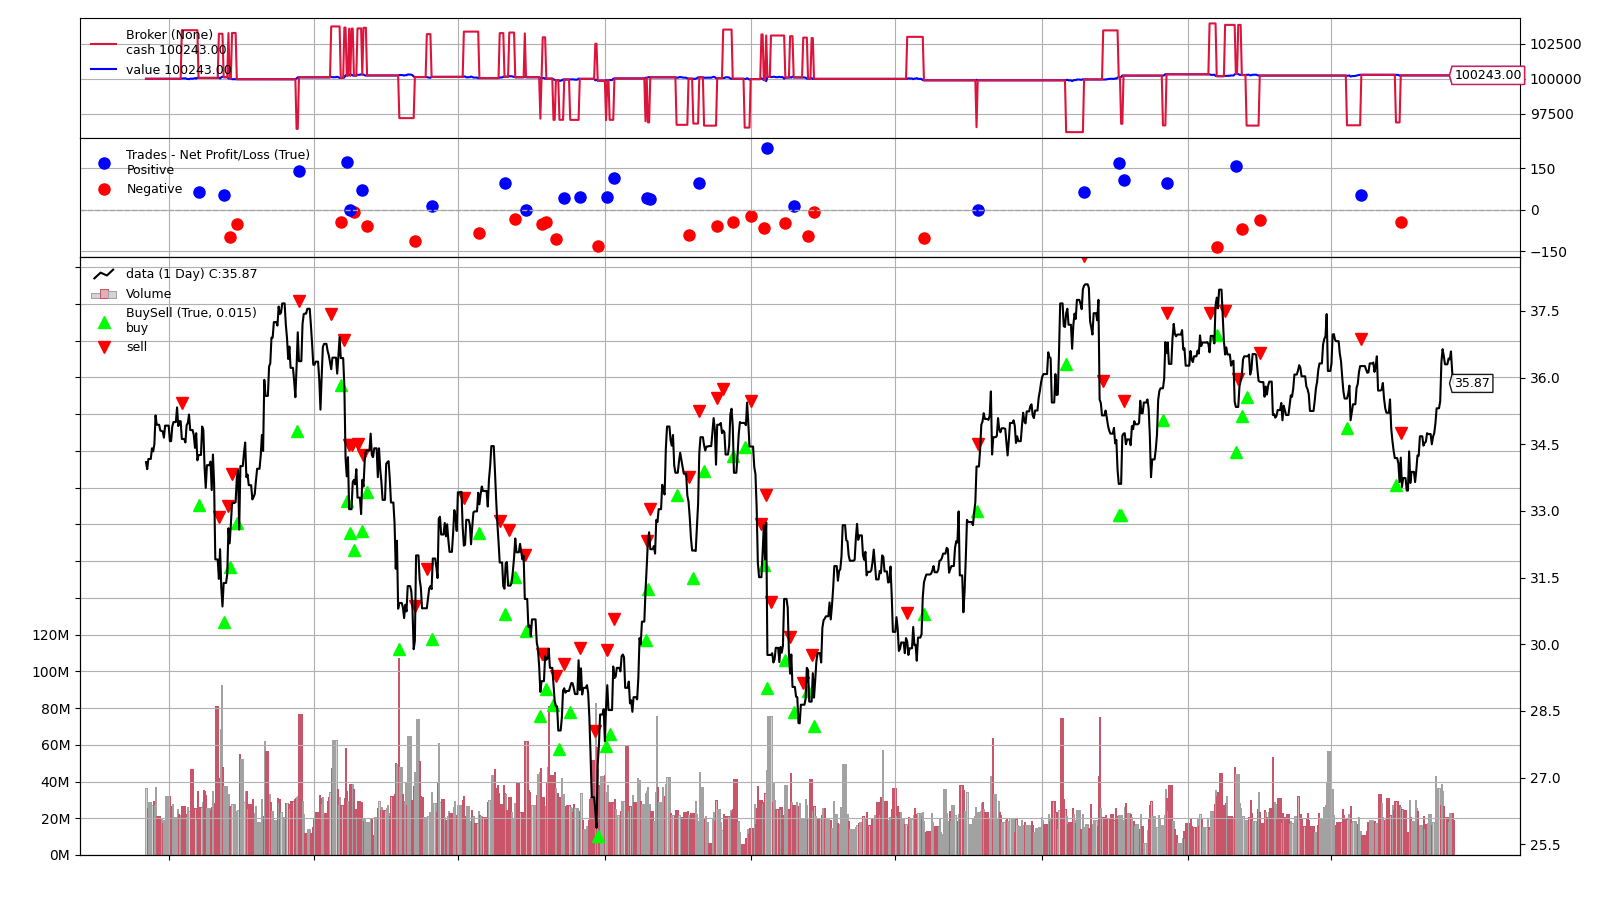

In [46]:
from IPython.display import Image
Image(filename='local/'+algo_name+'/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready, move on to the next step.

# Step 5) Backtest on SageMaker and submit performance

In [47]:
#Deploy Algo Image to ECS
!./build_and_push.sh $algo_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
[+] Building 0.2s (25/25) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/te

In [48]:
#Run Remote Forwardtest via SageMaker
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+algo_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+algo_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
#config['sim_data']='True'
print(config)

prefix=algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: algo-ml-long-short-predict-2025-06-11-21-44-03-098


s3://sagemaker-us-east-1-616431823260/data
{'user': 'user', 'long_threshold': '0.5', 'short_threshold': '0.5', 'profit_target_pct': '2.00', 'stop_target_pct': '1.50', 'size': '100', 'algo_name': 'algo_ml_long_short_predict', 'account': '616431823260', 'region': 'us-east-1'}
2025-06-11 21:44:04 Starting - Starting the training job...
2025-06-11 21:44:19 Starting - Preparing the instances for training...
2025-06-11 21:44:44 Downloading - Downloading input data...
2025-06-11 21:45:14 Downloading - Downloading the training image...
2025-06-11 21:46:05 Training - Training image download completed. Training in progress....import:algo_ml_long_short_predict
Using TensorFlow backend.
<class 'algo_ml_long_short_predict.MyStrategy'>
[INIT]:config:/opt/ml/input/config/hyperparameters.json={'account': '616431823260', 'algo_name': 'algo_ml_long_short_predict', 'long_threshold': '0.5', 'profit_target_pct': '2.00', 'region': 'us-east-1', 'short_threshold': '0.5', 'size': '100', 'stop_target_pct': '1.5

In [49]:
#Get Algo Metrics
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,algo:pnl,243.00
1,0.0,algo:sharpe_ratio,-4.46


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


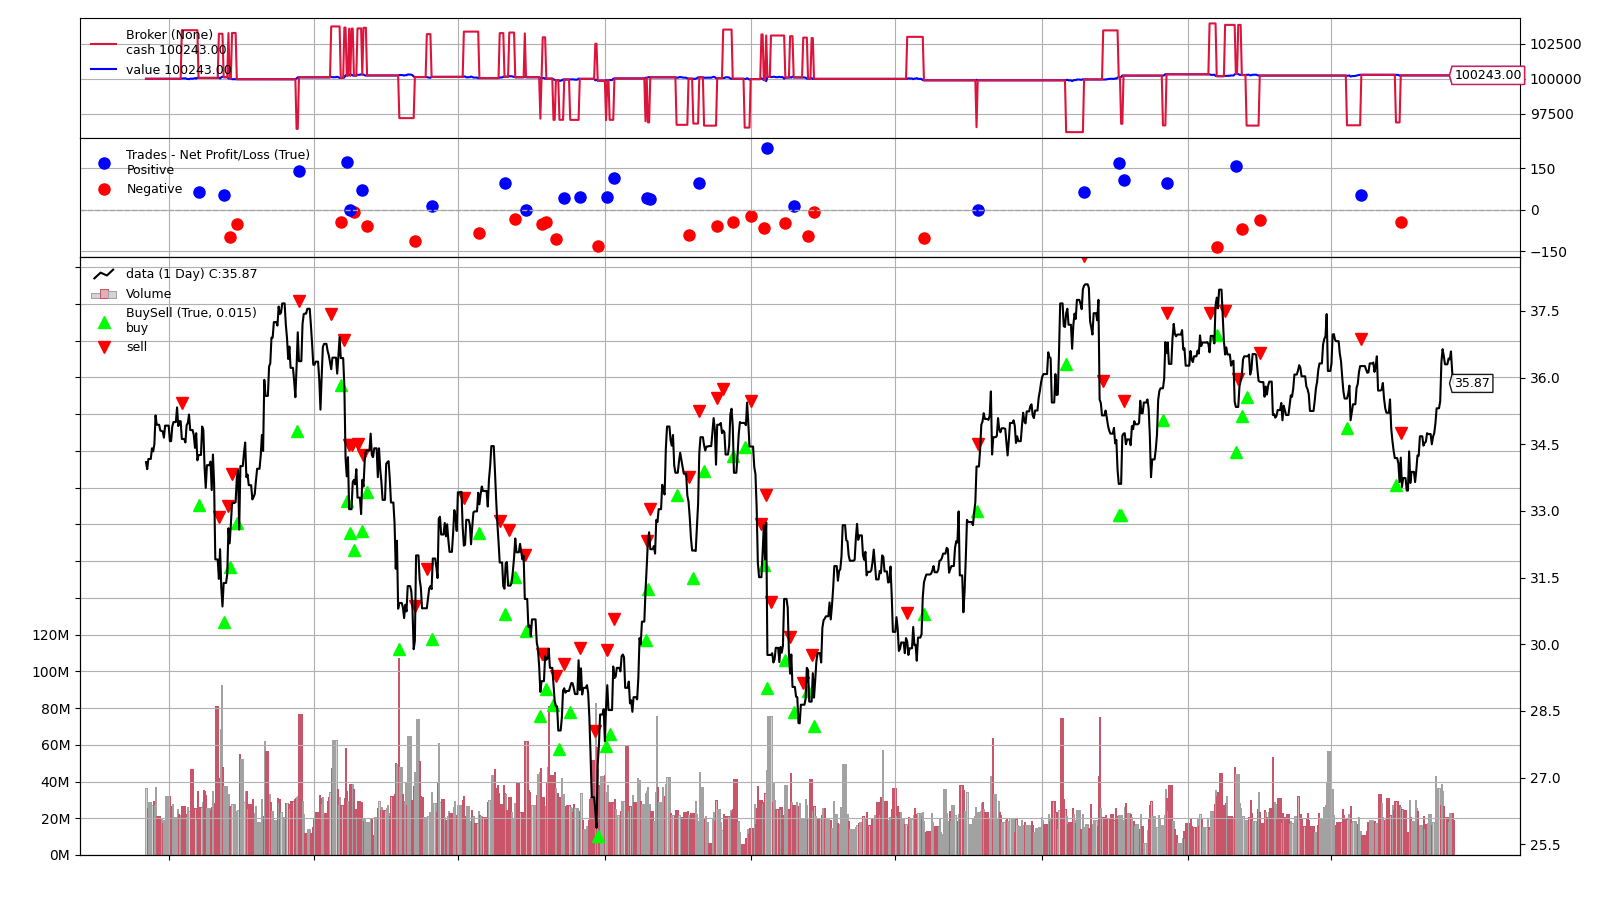

In [50]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 

### Congratulations! You've completed this strategy.